In [1]:
# !pip install tensorboard tensorflow pandas

"""
If tensorboard is not installed (or other dependencies, such as tensorflow and pandas),
uncomment the command in top and re-run. This needs only to be run once in a Jupyter kernel.
"""

%load_ext tensorboard

from tensorflow.python.summary.summary_iterator import summary_iterator
import pandas as pd
from pathlib import Path
import subprocess
import yaml
import os
import json
from collections.abc import MutableMapping

/home/chris/anaconda3/envs/qpe/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
!tensorboard dev upload --logdir \
    '../logging'

In [ ]:
"""
Change the LOG_DIR argument to point to the correct directory, you may want to use an
absolute path if you run into issues.
"""
# !!kill 22140
%tensorboard --logdir ./logging

In [2]:
def logs_to_pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """

    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": [], "wall_time": []})
    try:
        event_acc = summary_iterator(path)
        for event in list(event_acc)[1:]:
            step, wall_time = event.step, pd.to_datetime(event.wall_time, unit='s')
            simple_extractor = [{"metric": v.tag, "value": v.simple_value, "step": step, 'wall_time': wall_time} for v in event.summary.value]
            event_r = pd.DataFrame(simple_extractor)
            runlog_data = pd.concat([runlog_data, event_r])
    #Dirty catch of DataLossError
    except Exception as e:
        raise(e)
        print("Event file possibly corrupt: {}".format(path))
        print(e)
    return runlog_data

In [8]:
print("collecting log results..")
# creates dictionary: <id, event log dataframe>
dict_log_results = {}
logs = subprocess.getoutput(f'kubectl get pods -n test -l "app.kubernetes.io/name=fltk.extractor" -o jsonpath="{{.items[0].metadata.name}}"')
print(subprocess.getoutput("rm -rf logging"))
print("getting output.. ", subprocess.getoutput(f"kubectl cp -n test {logs}:logging ./logging"))
for path in Path('./logging').rglob('*events.out*'):
    path_iid = path.name.split("trainjob-")[1].split("-master")[0]
    dict_log_results[path_iid] = logs_to_pandas(f"./{path}")
    
print("\n finished creating log dictionary: DICT_LOG_RESULTS")

collecting log results..

getting output..  
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

 finished creating log dictionary: DICT_LOG_RESULTS


In [10]:
def flatten_dict(d: MutableMapping, sep: str= '.') -> MutableMapping:
    [flat_dict] = pd.json_normalize(d, sep=sep).to_dict(orient='records')
    return flat_dict

try: 
    os.mkdir("./logging/configmaps") 
except OSError as error: 
    print(error)
    
def job_to_id(job_name: str):
    return job_name.split("master-")[1][:-2]

job_ids = [i for i in subprocess.getoutput("kubectl get configmap --all-namespaces").split(" ") if "master" in i]
job_ids = [j for j in job_ids if job_to_id(j) in dict_log_results.keys()] # union with log results
      
print(f"collecting {len(job_ids)} configmaps ..")
dict_configmaps =  {}
for j in job_ids:
    try:
        # fetching from cloud and saving in logging/configmaps/-id-.txt
        config_map = subprocess.getoutput(f"kubectl get configmaps {j} -o yaml -n test")
        text_file = open(f"./logging/configmaps/{j}.txt", "w")
        n = text_file.write(config_map)
        text_file.close()
        print("fetched! caching..")
    except Exception as e:
        # in case of error (e.g. not in cloud), fetch from cache
        print("error, finding in cache.. ")
        with open(f"./logging/configmaps/{j}.txt", 'r') as file:
            config_map = file.read().replace('\n', '')
        
    dict_configmaps[job_to_id(j)] = flatten_dict(yaml.safe_load(yaml.safe_load(config_map)['data']['node.config.yaml']))
    
print("finished collecting configmaps, see DICT_LOG_RESULTS")

[Errno 17] File exists: './logging/configmaps'
collecting 20 configmaps ..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
fetched! caching..
finished collecting configmaps, see DICT_LOG_RESULTS


In [193]:
import pickle

# --- Creating clusters ---
experiments = [(idd, set(value.items())) for idd, value in dict_configmaps.items()]
clusters = []
diff_attr_total = set() # set of total different attr values found between experiments
while len(experiments) > 0:
    next_exp = experiments[0]
    cluster = list([next_exp])
    for e in experiments[1:]:
        diff_attr = next_exp[1].difference(e[1])
        diff_attr_total = diff_attr_total.union(set([s[0] for s in diff_attr]))
        if len(diff_attr) <= 1:
            print(next_exp[1].difference(e[1])) # should only be seed difference!!!
            cluster.append(e)
    for e in cluster:
        experiments.remove(e)
    clusters.append(cluster)

# --- Combining dataframes of clusters ---
cluster_ids = [[e[0] for e in exp_l] for exp_l in clusters]
id_archieved_metric = {}
for k,v in dict_log_results.items():
    df = v.drop_duplicates('metric', keep='last')
    df.insert(0, 'exp_id', k)
    for attr in diff_attr_total:
        df.insert(0, attr, dict_configmaps[k][attr])
    id_archieved_metric[k] = df

cluster_to_metrics = [(ids, pd.concat([id_archieved_metric[i] for i in ids])) for ids in cluster_ids]
cluster_to_metrics_katja = pickle.load(open("cluster_to_metrics_katja.pkl", "rb"))

# print(cluster_to_metrics_katja[0][1])
#--- filter out old experiments (e.g. batch size not 100) ----
cluster_to_metrics = [(ids, df) for ids, df in cluster_to_metrics if df['batch_size'].mode().iloc[0] == 100]
print(type(cluster_to_metrics))
# for _, df in cluster_to_metrics:
#     df.insert(0, 'parallel', 2)
# print(type(cluster_to_metrics_katja))

for _, df in cluster_to_metrics_katja:
    df.insert(0, 'parallel', 16)
    
cluster_to_metrics += cluster_to_metrics_katja


combined_df = pd.concat([df for _, df in cluster_to_metrics])

combined_df.rename(columns = {'service_time_budget':'stb', 'model_size':'ms', "learning_rate": "lr", "parallel": "p"}, inplace = True)

# open a file, where you ant to store the data
file = open('experiment_1.pkl', 'wb')

# dump information to that file
pickle.dump(combined_df, file)

# close the file
file.close()


combined_df = pickle.load(open("experiment_1.pkl", "rb"))

combined_df = combined_df[combined_df["metric"] == "accuracy per epoch"]


# print(combined_df)

{('seed', 539797574)}
{('seed', 698416725)}
{('seed', 1977273656)}
{('seed', 1977273656)}
{('seed', 391183769)}
{('seed', 2469606724)}
{('seed', 4006973926)}
{('seed', 4006973926)}
{('seed', 3828286053)}
{('seed', 3393082523)}
{('seed', 3393082523)}
<class 'list'>


In [194]:
# print(anova_df)
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

func = 'value ~ ms * stb * lr * p'
model = ols(func, data=combined_df).fit()

# func += '+ '
# # model = ols('value ~ C(model_size) + C(service_time_budget) + C(model_size):C(service_time_budget)', data=combined_df).fit()
# df = combined_df[combined_df["parallel"] == 2]
# df.plot.scatter(x='service_time_budget', y='value', c='model_size', colormap='viridis')
# df = combined_df[combined_df["parallel"] == 16]
# df.plot.scatter(x='service_time_budget', y='value', c='model_size', colormap='viridis')
# combined_df.plot.scatter(x='service_time_budget', y='value', c='model_size', colormap='viridis')

# combined_df.plot(x='learning_rate', y='value', style='o')

df_stats = sm.stats.anova_lm(model, typ=2)
# print(df_stats.to_latex(index=True))
df_stats

,sum_sq,df,F,PR(>F)
ms,0.105600,1.0,0.195857,6.616108e-01
stb,5.157656,1.0,9.565989,4.569953e-03
ms:stb,3.831308,1.0,7.105991,1.281312e-02
lr,0.220262,1.0,0.408523,5.281057e-01
ms:lr,1.231928,1.0,2.284878,1.422574e-01
stb:lr,2.069485,1.0,3.838308,6.049494e-02
ms:stb:lr,0.021795,1.0,0.040424,8.421607e-01
p,157.885012,1.0,292.831940,5.093131e-16
ms:p,0.011764,1.0,0.021819,8.836666e-01
stb:p,1.691492,1.0,3.137239,8.781243e-02


180 1800
0.0005 0.003
0 2
180 1800
180 1800


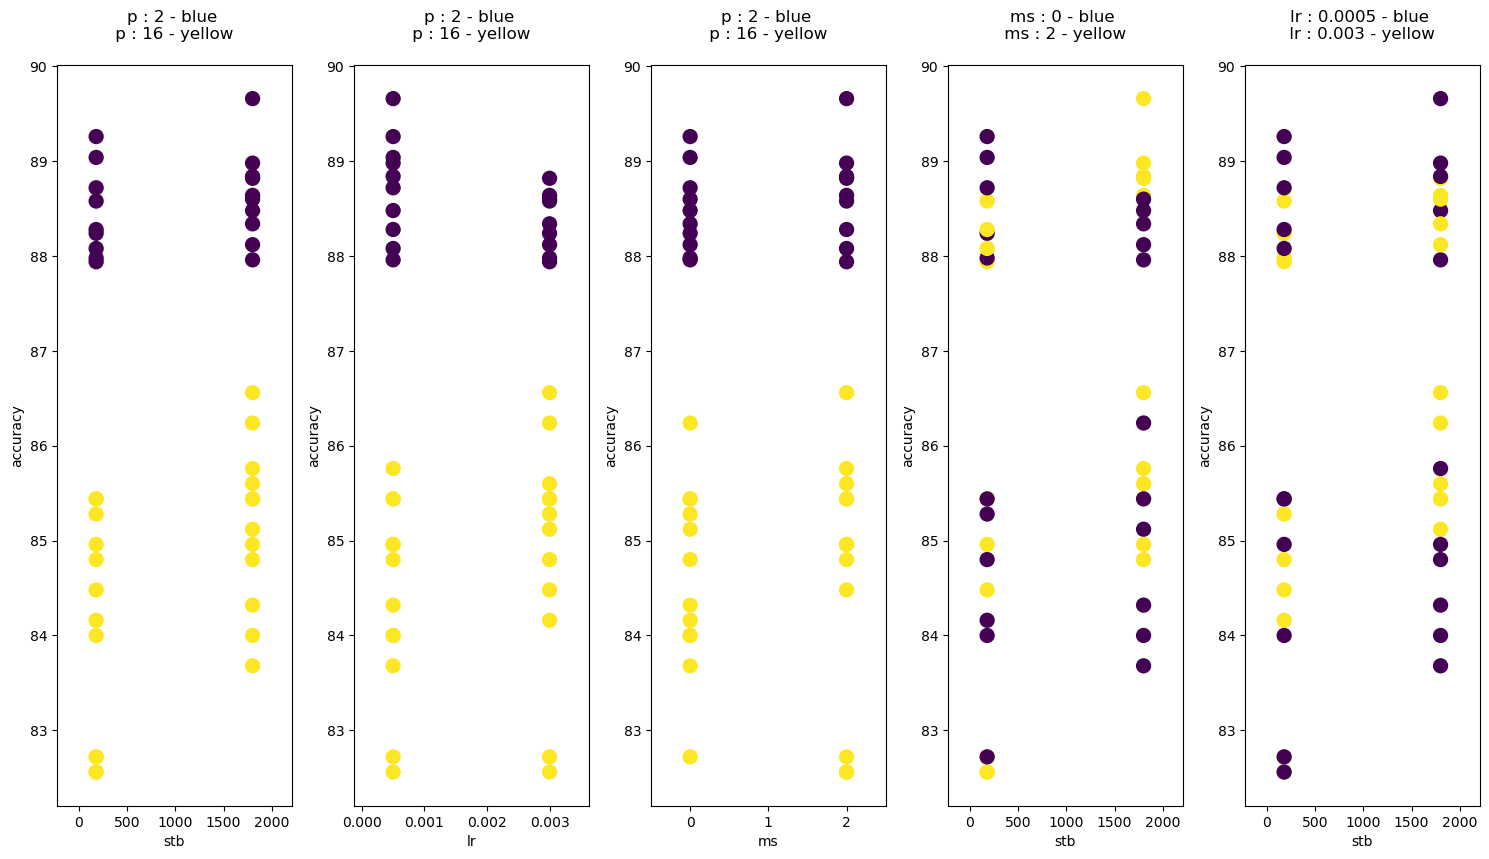

In [226]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(16,8), dpi=80)



options = [
    ("stb", "p"),
    ("lr", "p"),
    ("ms", "p"),
    ("stb", "ms"),
    ("stb", "lr")
]

fig, axs = plt.subplots(1, 5, figsize=(len(options) * 3, 8))
fig.tight_layout()
for a, (x, c) in enumerate(options):
    min_v, max_v = combined_df[x].min(), combined_df[x].max()
    print(min_v, max_v)
    avg = (min_v -- max_v) / 2
    dif = abs(avg - min_v)

    fig_params = {
        "x": x, #'learning_rate', 
        "y": 'value', 
        "ax": axs[a],
        "c": c, #'model_size', 
        "colormap": 'viridis', 
        "s": 100, 
        "colorbar": False,
        "ylabel": "accuracy",
        "fontsize": 10,
        "xlim": (avg - 1.5 * dif, avg -- 1.5 * dif),
        "title": f"{c} : {combined_df[c].min()} - blue \n {c} : {combined_df[c].max()} - yellow \n "
    }
    
#     plt.xlim(avg - 1.5 * dif, avg -- 1.5 * dif)
    res = combined_df.plot.scatter(**fig_params)
    

# plt.xlabel()
# cbar = plt.colorbar()
# cbar.remove()
fig.savefig("hoi1.jpg")
plt.savefig("hoi2.jpg")
# fig.show()